In [105]:
import cv2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob

# For our model
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sys import platform
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# from colorizerII import colorizer
# from cnnColorizer import colorizer, trainModel


ModuleNotFoundError: No module named 'nn'

### Helper Functions

In [2]:
def load(folder):
    files = glob.glob(folder)
    data =[]
    for f in files:
        image = cv2.imread(f)
        data.append(image)
    return data


def LoadLabInOrder(folder):

    # find the largest number file to index (do not worry about how these next few lines work)
    files = glob.glob(folder + "*L.jpg")
    for i, f in enumerate(files):
        f = f[f.rfind('/')+1:]
        files[i] = f[0:f.rfind('.')-1]
    maxFileNum = max([int(f) for f in files])
    
    # for each file index (e.g. ['0a.jpg', '0b.jpg', '0L.jpg'])
    data = []
    for i in range(0, maxFileNum):
        # grab files in order 'a', 'b', 'L'
        files = sorted(glob.glob(folder + str(i) + "?.jpg"), key=str.casefold)

        # append each file
        for f in files:
            image = cv2.imread(f)

            # only take one channel (all the channels here are the same)
            data.append(image)
        
    return data


def group(data, album_length):
    #group into chunks of three because of three sets of images in LAB color space
    for i in range (0, album_length, 3):
        yield data[i:i+3]
  
def make_numpy_format(image):
    image = torch.swapaxes(image, 0, 1)
    image = torch.swapaxes(image, 1, 2)
    return image

def make_tensor(image):
    image = np.swapaxes(image, 2,1)
    image = np.swapaxes(image, 1,0)
    return image


class imageDataset(Dataset):
    def __init__(self,  l_color_space, ab_color_space,):
        #dropping redundant channels
        a = (ab_color_space[:, 0])
        b = (ab_color_space[:, 1])
        l = (l_color_space)
        

        #it seems that I will have to use permute 
        #to get from numpy image representation
        #to torch tensor image 
        
        self.a = a
        self.b = b
        self.l = l
        self.indices = len(l)
        
    def __len__(self):
        return self.indices
      
    
    def __getitem__(self, index):
        return self.a[index], self.b[index], self.l[index]    
    
    
def convert_LAB(album):
    converted_album = [[] for _ in range( len(album))]
    
    #code borrowed from https://towardsdatascience.com/computer-vision-101-working-with-color-images-in-python-7b57381a8a54
    for index, image in enumerate(album):
        #do LAB conversion here
        image = np.asarray(image).astype('uint8')
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        names = []
        channels = []
        
        for (name, chan) in zip(("L", "a", "b"), cv2.split(converted_image)):
            names.append(name)
            channels.append(chan)
           # cv2.imshow(name, chan)
           
        converted_album[index] = list(zip(names, channels))
              
    return converted_album
        
def saveLAB(album, folder_name):
    subfolder_dir = os.path.join(os.getcwd(), folder_name)
    
    if not os.path.exists(subfolder_dir):
        os.mkdir(subfolder_dir)

    count = 0
    #each entry inside an LAB color space album is a tuple
    for tup in album:
       # image = image.cpu().detach().numpy()
       names, channels = zip(*tup)
       
       for i in range(len(channels)):
           name = names[i]
           channel = channels[i]
           cv2.imwrite(subfolder_dir + slash + str(count) + name + '.jpg', channel)
           
      
       count +=1


### Get Original Images, Convert to Lab, Save

In [3]:
if platform == 'darwin':
    slash = '/'
else: 
    slash = '\\'

    
home_dir = os.getcwd() 

#change this parameter depending on which album you want
target_album = 'ColorfulLab'
if target_album == 'LAB_TEST_FACES':
    album = 'faces'
else:
    album = 'ColorfulLab'

# if the specified directory does not exist, or if it exists but is empty
if not os.path.exists(home_dir + slash + target_album) \
    or (os.path.exists(home_dir + slash + target_album) and not [name for name in os.listdir("." + slash + target_album)]):

    # get names of folders for colorful fruit data
    foodFolders = [name for name in os.listdir("." + slash + target_album)]

    # get fruit images
    food_images = []
    for ff in foodFolders:
        food_images.extend(load(home_dir + slash + target_album + slash + ff + slash + '*.jpg'))

    # album_length = len(food_images)

    for i, val in enumerate(food_images):
        food_images[i] = cv2.resize(val, (128, 128))
    food_images_lab = convert_LAB(food_images)
    saveLAB(food_images_lab, "ColorfulLab")

    # plot rgb image
#     plt.imshow(cv2.cvtColor(food_images[0], cv2.COLOR_BGR2RGB))

### Load Images

In [4]:
batch_size = 32
Epochs = 100
lr = 0.01
criterion = nn.MSELoss()
torch.set_default_tensor_type(torch.FloatTensor)

home_dir = os.getcwd() 
#change this parameter depending on which album you want
target_album = 'ColorfulLab'
if target_album == 'LAB_TEST_FACES':
    album = 'faces'
else:
    album = 'ColorfulLab'


food_data = LoadLabInOrder(home_dir + slash + target_album + slash)
album_length = len(food_data)

#group images into sets of 3   
food_grouped_data = list(group(food_data, album_length))
food_grouped_data = np.asarray(food_grouped_data)
    
#prepare grouped data for training and test
food_train_images, food_test_images = train_test_split(food_grouped_data, test_size = 0.3)
food_train_images, food_val_images = train_test_split(food_train_images, test_size = 0.1)

#further separate them into X's and Y's where L is the input and AB are the targets (LAB colorspace)
#remember the dimensions are Number of grouped images X Index of image
#this needs to be flipped

food_X_train = food_train_images[:, 2, :, :, 0]#.astype(dtype=object)
food_y_train = food_train_images[:, 0:2, :, :, 0]#.astype(dtype=object)

food_X_test = food_test_images[:, 2, :, :, 0]#.astype(dtype=object)
food_y_test = food_test_images[:, 0:2, :, :, 0]#.astype(dtype=object)

food_X_val = food_test_images[:, 2, :, :, 0]#.astype(dtype=object)
food_y_val = food_test_images[:, 0:2, :, :, 0]#.astype(dtype=object)


#prepare datasets for images
food_train_dataset = imageDataset(food_X_train, food_y_train)
food_test_dataset = imageDataset(food_X_test, food_y_test)
food_val_dataset = imageDataset(food_X_val, food_y_val)

# prepare dataloaders for batch training
food_train_loader = torch.utils.data.DataLoader(dataset = food_train_dataset, batch_size = batch_size, shuffle=True)
food_test_loader = torch.utils.data.DataLoader(dataset = food_test_dataset,  batch_size = batch_size, shuffle=True)
food_val_loader = torch.utils.data.DataLoader(dataset = food_val_dataset,  batch_size = batch_size, shuffle=True)


In [5]:
# def my_collate(batch):
#     for i, val in enumerate(batch):
#         print(val[0].shape)
#         print(val[1].shape)
#         print(val[2].shape)
            
#     data = [item[0] for item in batch]
#     target1 = [item[1] for item in batch]
#     target2 = [item[2] for item in batch]
#     target = torch.Tensor([target1, target2])
#     return [data, target]


# # #prepare dataloaders for batch training
# food_train_loader = torch.utils.data.DataLoader(dataset = food_train_dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)
# food_test_loader = torch.utils.data.DataLoader(dataset = food_test_dataset,  batch_size = batch_size, shuffle=True, collate_fn=my_collate)
# food_val_loader = torch.utils.data.DataLoader(dataset = food_val_dataset,  batch_size = batch_size, shuffle=True, collate_fn=my_collate)

In [10]:
def trainModel(color, trainLoader, valLoader, optimizer, epochs, album):

    #training loop: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    #loss_values = []
    train_loss = []
    validation_loss = []
    val_ticker = 0
    last_loss = 20000

    # rows, cols = (2, Epochs)
    # stored_images = [[0 for i in range(cols)] for j in range(rows)]

    for epoch in range(epochs):  # loop over the dataset multiple times
        color.train()
    
        running_loss = 0.0
        #I want batch to be of length 10 not 3 why?
        for i, img in enumerate(trainLoader):
            
            a = img[0] # i changed these for clarity and less typing i didn't want to type batch everytime -hmk
            b = img[1]
            l = img[2]
        
            
            #each batch is ten images so loop through all the images per batch
            # no!!!! this defeats the point of batches if you loop through each image you've essentially made your batch size 1 -hmk
            
            # for index, images in enumerate(batch):
                # get the inputs; data is a list of tensors [chrominance_a_tensor, chrominance_b_tensor, grayscale_l_tensor]
                # different images!
        
        
            #labels = torch.tensor((label_a, label_b))
            #might not be necessary to drop duplicates
            labels = torch.stack((a, b), 1).float().to(device)
            input_l = torch.unsqueeze(l, 1).to(device)
        
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = color((input_l))
            # outputs = outputs.view(2, size)
            
            #flatten labels along dimension 0
            labels = torch.flatten(labels, 0, 1)
            
            
            loss = criterion(outputs, labels)
        
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
                    
        train_loss.append(loss)

        if epoch % 10 == 0:
            running_val_loss = 0.0
            with torch.no_grad():
                color.eval()
                for data in valLoader:
                    val_l = torch.unsqueeze(data[2], 1).to(device)
                    val_outputs = color(val_l)
                    val_labels = torch.stack((data[0], data[1]), 1).float().to(device)
                    val_loss = criterion(val_outputs, torch.flatten(val_labels, 0, 1))
                    running_val_loss += val_loss

            validation_loss.append(running_val_loss)
            print("\nNumber Of Images Tested =", len(valLoader)*batch_size)
            print("Validation MSE Loss =", (running_val_loss/len(valLoader)))

            if (running_val_loss/len(valLoader)) - last_loss >= 0.1:
                path = f"./chkpt_{album}/color_model_{epoch}.pt"
                torch.save(color.state_dict(), path)
            last_loss = (running_val_loss/len(valLoader))

            # once done with a loop I want to print out the target image 
            # # and colorized image for comparison    
            # sample_target = cv2.merge([l[0].detach().numpy(), a[0].detach().numpy(), b[0].detach().numpy()]) 
            # sample_target = cv2.cvtColor(sample_target, cv2.COLOR_LAB2RGB)
            #plt.imshow(sample_target)
            
            sample_target = cv2.merge([l[0].cpu().detach().numpy(), a[0].cpu().detach().numpy(), b[0].cpu().detach().numpy()]) 
            sample_target = cv2.cvtColor(sample_target, cv2.COLOR_LAB2RGB)
            #plt.imshow(sample_target)
        
            colorized_a = outputs[0].cpu().detach().numpy().astype(np.uint8)
            colorized_b = outputs[1].cpu().detach().numpy().astype(np.uint8)
            sample_colorized = cv2.merge([l[0].detach().numpy(), colorized_a, colorized_b])
            sample_colorized = cv2.cvtColor(sample_colorized, cv2.COLOR_LAB2RGB)
            #plt.imshow(sample_colorized)                   dont need these anymore bc im just saving the images as pngs instead -hmk
            # stored_images[0][epoch] = sample_target
            # stored_images[1][epoch] = sample_colorized
            cv2.imwrite(f"./chkpt_{album}/images/target_image_{epoch}.png",sample_target)
            cv2.imwrite(f"./chkpt_{album}/images/output_image_{epoch}.png",sample_colorized) # -hmk

        print('Epoch {} of {}, Training MSE Loss: {:.3f}'.format( epoch+1, epochs, running_loss/len(trainLoader)))

In [204]:
# from cnnColorizer import colorizer
# cModel = torch.load('../saved_models/model_architecture_11.pt')
path = "../color_model_80.pt"
cModel = colorizer()
cModel.load_state_dict(torch.load(path))

path = os.getcwd() + "/saved_models/model_architecture_11.pt"
cModel = torch.load(path)

cModel.eval()
for i, param in enumerate(cModel.parameters()):
    if i != 10:
        param.requires_grad = False


In [205]:
cModel.downsamp6 = nn.Sequential(nn.Conv2d(2, 64, kernel_size=(2, 2), stride=(2, 2)),
                            nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
cModel.downsamp6.requires_grad = True
cModel.downsamp7 = nn.Sequential(nn.Conv2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
                            nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
cModel.downsamp7.requires_grad = True
cModel.downsamp8 = nn.Sequential(nn.Conv2d(32, 16, kernel_size=(2, 2), stride=(2, 2)),
                            nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
cModel.downsamp8.requires_grad = True
cModel.downsamp9 = nn.Sequential(nn.Conv2d(16, 8, kernel_size=(2, 2), stride=(2, 2)),
                            nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
cModel.downsamp9.requires_grad = True

cModel.upsamp6 = nn.Sequential(nn.ConvTranspose2d(2, 64, kernel_size=(2, 2), stride=(2, 2)),
                            nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
cModel.downsamp6.requires_grad = True
cModel.upsamp7 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
                            nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
cModel.downsamp7.requires_grad = True
cModel.upsamp8 = nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2)),
                            nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
cModel.downsamp8.requires_grad = True
cModel.upsamp9 = nn.Sequential(nn.ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2)),
                            nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
cModel.downsamp9.requires_grad = True



In [206]:
#run color regressor
lr = 0.01
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(cModel.parameters(), lr)
trainModel(cModel, food_train_loader, food_val_loader, optimizer, 90, 'fruit')


Number Of Images Tested = 224
Validation MSE Loss = tensor(543.7509)
Epoch 1 of 90, Training MSE Loss: 593.719
Epoch 2 of 90, Training MSE Loss: 594.716
Epoch 3 of 90, Training MSE Loss: 583.651
Epoch 4 of 90, Training MSE Loss: 579.308
Epoch 5 of 90, Training MSE Loss: 573.109
Epoch 6 of 90, Training MSE Loss: 581.310
Epoch 7 of 90, Training MSE Loss: 573.104
Epoch 8 of 90, Training MSE Loss: 565.123
Epoch 9 of 90, Training MSE Loss: 554.395
Epoch 10 of 90, Training MSE Loss: 558.606

Number Of Images Tested = 224
Validation MSE Loss = tensor(551.7083)
Epoch 11 of 90, Training MSE Loss: 555.678
Epoch 12 of 90, Training MSE Loss: 549.898
Epoch 13 of 90, Training MSE Loss: 539.528
Epoch 14 of 90, Training MSE Loss: 520.044
Epoch 15 of 90, Training MSE Loss: 490.785
Epoch 16 of 90, Training MSE Loss: 475.044
Epoch 17 of 90, Training MSE Loss: 453.725
Epoch 18 of 90, Training MSE Loss: 470.361
Epoch 19 of 90, Training MSE Loss: 456.571
Epoch 20 of 90, Training MSE Loss: 460.377

Number O

In [208]:
running_test_loss = 0.0
result = []
with torch.no_grad():
    cModel.eval()
    for i, data in enumerate(food_test_loader):
        test_l = torch.unsqueeze(data[2], 1).to(device)
        test_outputs = cModel(test_l)
        test_labels = torch.stack((data[0], data[1]), 1).float().to(device)
        test_loss = criterion(test_outputs, torch.flatten(test_labels, 0, 1))
        running_test_loss += test_loss
        
        if i == len(food_test_loader)-1:

            a = data[0]
            b = data[1]
            l = data[2]

            test_l = torch.unsqueeze(l, 1).to(device)
            outputs = cModel(test_l)
            test_a = torch.unsqueeze(a, 1).to(device)
            test_b = torch.unsqueeze(b, 1).to(device)

print("\nNumber Of Images Tested =", len(food_test_loader)*batch_size)
print("Testing MSE Loss =", (running_test_loss/len(food_test_loader)))


Number Of Images Tested = 224
Testing MSE Loss = tensor(470.0614)


In [196]:
# thing = torch.stack((torch.squeeze(test_l), torch.squeeze(test_a), torch.squeeze(test_b)), axis=1)

/var/folders/6q/lnztzmln25l88yjxl7j0pxth0000gn/T/ipykernel_51962/892395072.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


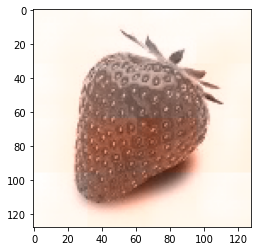

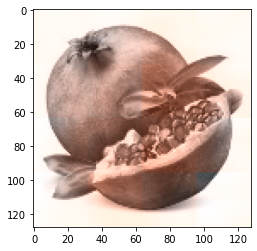

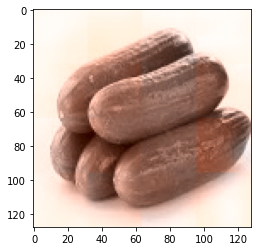

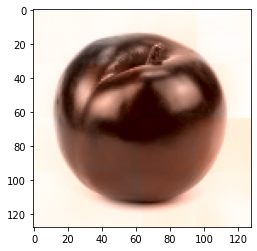

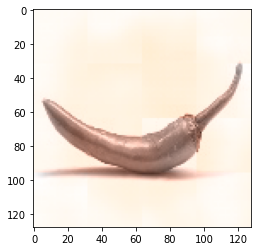

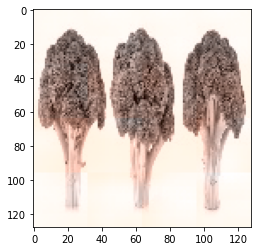

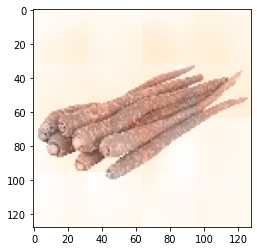

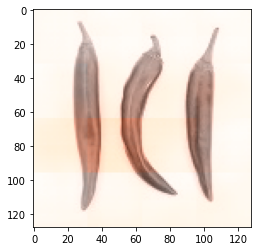

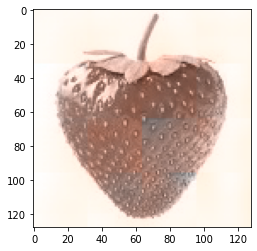

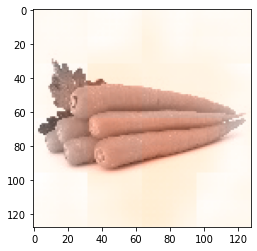

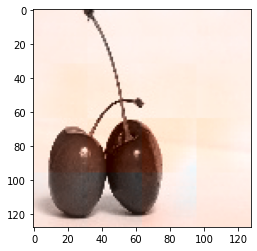

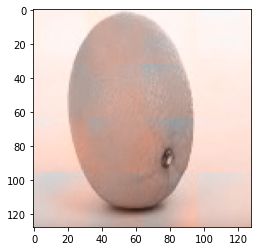

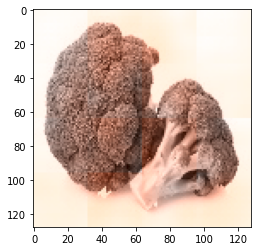

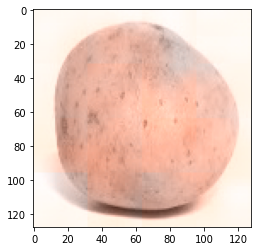

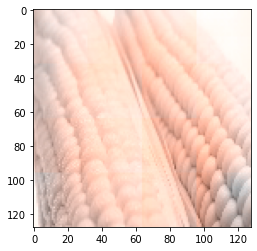

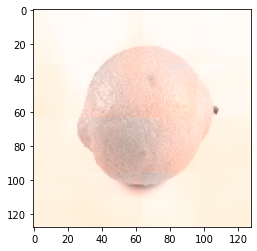

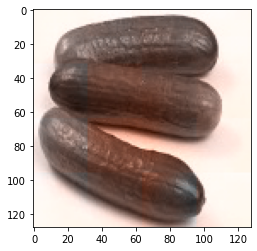

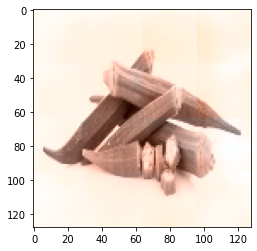

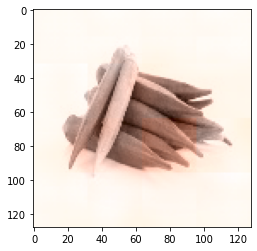

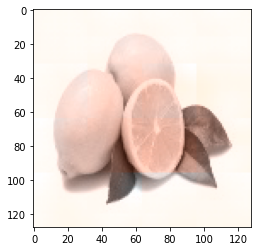

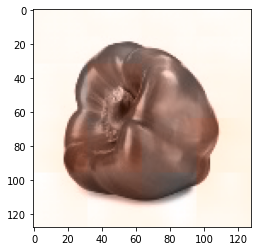

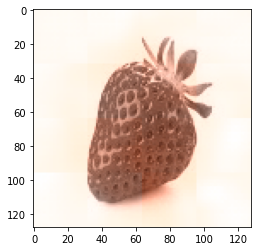

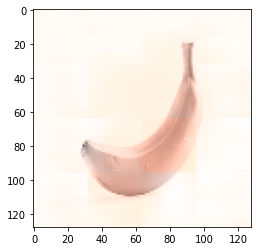

In [209]:
for i in range(1, l.shape[0]):
    colorized_a = outputs[2*i-2].cpu().detach().numpy().astype(np.uint8)
    colorized_b = outputs[2*i-1].cpu().detach().numpy().astype(np.uint8)
    colorized_l = l[i].detach().numpy()
    sample_colorized = cv2.merge([colorized_l, colorized_a, colorized_b])
    sample_colorized = cv2.cvtColor(sample_colorized, cv2.COLOR_LAB2RGB)
    plt.figure()
    plt.imshow(sample_colorized)

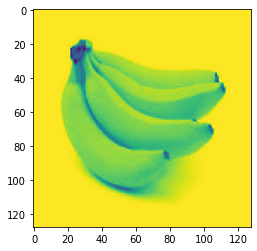

In [89]:
# thing = next(iter(food_test_loader))